# Fraudulent Transaction Detection

## Introduction and Preprocessing Details
#### The task was to detect fraudulent transactions in a highly imbalanced credit card dataset. Initially, the unsupervised anomaly detection algorithm, Isolation Forest, was chosen with the assumption that it could effectively identify outliers representing fraudulent transactions.

# Code

### Import libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.svm import OneClassSVM
from imblearn.over_sampling import SMOTE

### Data Upload
- It would be necessary to upload the path of dataset.

In [3]:
dataset_path = '/content/creditcard.csv'
raw_data = pd.read_csv(dataset_path)
print(raw_data.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [3]:
# Check missing value.
print(raw_data.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


##### There is no missing value.

In [4]:
print(raw_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Overall statistics

In [5]:
print(raw_data.describe().round(2))

            Time         V1         V2         V3         V4         V5  \
count  284807.00  284807.00  284807.00  284807.00  284807.00  284807.00   
mean    94813.86       0.00       0.00      -0.00       0.00       0.00   
std     47488.15       1.96       1.65       1.52       1.42       1.38   
min         0.00     -56.41     -72.72     -48.33      -5.68    -113.74   
25%     54201.50      -0.92      -0.60      -0.89      -0.85      -0.69   
50%     84692.00       0.02       0.07       0.18      -0.02      -0.05   
75%    139320.50       1.32       0.80       1.03       0.74       0.61   
max    172792.00       2.45      22.06       9.38      16.88      34.80   

              V6         V7         V8         V9  ...        V21        V22  \
count  284807.00  284807.00  284807.00  284807.00  ...  284807.00  284807.00   
mean        0.00      -0.00       0.00      -0.00  ...       0.00      -0.00   
std         1.33       1.24       1.19       1.10  ...       0.73       0.73   
min 

### Copy data

In [6]:
data = raw_data.copy()

### Data preprocessing
- Even though the dataset (V1 to V28) has already undergone PCA, the `Time` and `Amount` variables were standardized because they are features used in the model.

In [7]:
# Split data

X = data[['Time', 'Amount'] + [f'V{i}' for i in range(1, 29)]]
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50, stratify=y)

# Scale only 'Time' and 'Amount' for both training and test sets
scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and test sets for 'Time' and 'Amount'
X_train[['Time', 'Amount']] = scaler.fit_transform(X_train[['Time', 'Amount']])
X_test[['Time', 'Amount']] = scaler.transform(X_test[['Time', 'Amount']])

### Modularization of training_model(isolation forest)

In [8]:
# contamination (float): Approximate proportion of frauds (anomalies) - 0.00172.
# n_estimators (int): Number of trees.
# max_samples (int): Number of samples for each tree.
# n_splits (int) : account of folds

def train_isolation_forest(X, n_splits=5, n_estimators=100, max_samples=256, bootstrap=False, param_distributions = None, scoring='roc_auc', contamination=0.00172, n_iter=10):
    # Apply random_search
    if param_distributions is not None:
        # Initialize Isolation Forest model
        model = IsolationForest(random_state=50)

        # Initialize RandomizedSearchCV with cross-validation and the scoring parameter
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_distributions,
            scoring=scoring,
            cv=n_splits,
            n_iter=n_iter,
            n_jobs=-1,
            verbose=2
        )

        random_search.fit(X)

        return random_search.best_estimator_, random_search.cv_results_
    # Manually
    else:
        model = IsolationForest(n_estimators=n_estimators, max_samples=max_samples,
                                bootstrap=bootstrap, contamination=contamination, random_state=50)

        model.fit(X)

        return model, None

### Modularization of evaluating_model(isolation forest)

In [27]:
def evaluate_isolation_forest(model, X_test, y_test, threshold=0, as_graph=False):
    # Get the anomaly scores using decision_function
    anomaly_scores = model.decision_function(X_test)

    # Apply the custom threshold to classify as fraud (1) or normal (0)
    y_pred = np.where(anomaly_scores < threshold, 1, 0)

    cm = confusion_matrix(y_test, y_pred)

    # Because graph of distribution of anomaly scores is necessary for once.
    if as_graph == True :
      plt.figure(figsize=(10, 6))
      sns.histplot(anomaly_scores, bins=50, kde=True)
      plt.title('Anomaly Score Distribution')
      plt.xlabel('Anomaly Score')
      plt.ylabel('Frequency')
      plt.show()

    # Confusion Matrix and Classification Report
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # AUC-ROC Score for anomaly_scores
    auc_score_anomaly = roc_auc_score(y_test, anomaly_scores)
    print(f"AUC-ROC Score (Anomaly Scores): {auc_score_anomaly}")

    # AUC-ROC Score for y_pred
    auc_score_pred = roc_auc_score(y_test, y_pred)
    print(f"AUC-ROC Score (Predictions): {auc_score_pred}")

    # Accuracy Score
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")


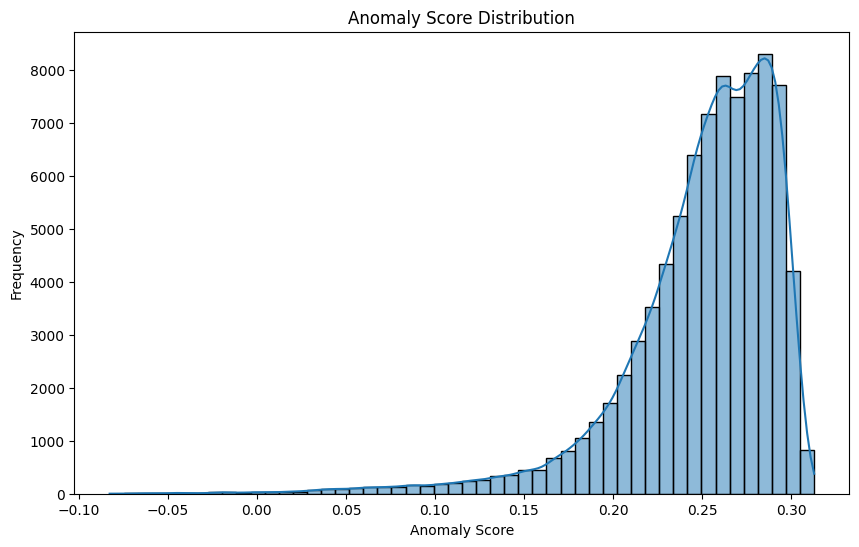

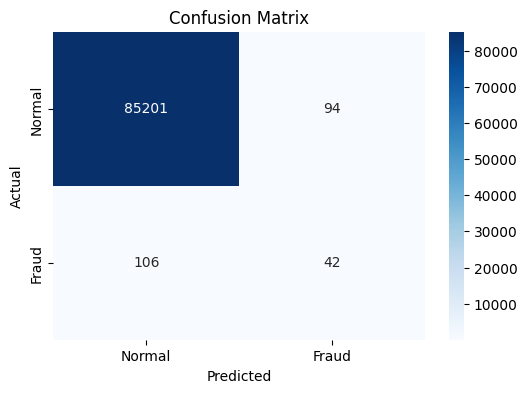


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.31      0.28      0.30       148

    accuracy                           1.00     85443
   macro avg       0.65      0.64      0.65     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC Score (Anomaly Scores): 0.06107206626287463
AUC-ROC Score (Predictions): 0.6413408631094311
Accuracy: 0.9976592582189295


In [28]:
model,_ = train_isolation_forest(X_train)

evaluate_isolation_forest(model, X_test, y_test, as_graph=True)

### Change parameter(max_samples)

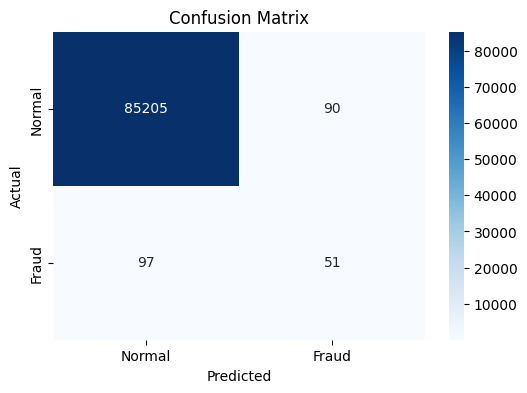


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.36      0.34      0.35       148

    accuracy                           1.00     85443
   macro avg       0.68      0.67      0.68     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC Score (Anomaly Scores): 0.05723189629631977
AUC-ROC Score (Predictions): 0.6717697165481326
Accuracy: 0.9978114064346991


In [29]:
model, _ = train_isolation_forest(X_train, n_estimators=200, max_samples=500)

evaluate_isolation_forest(model, X_test, y_test)

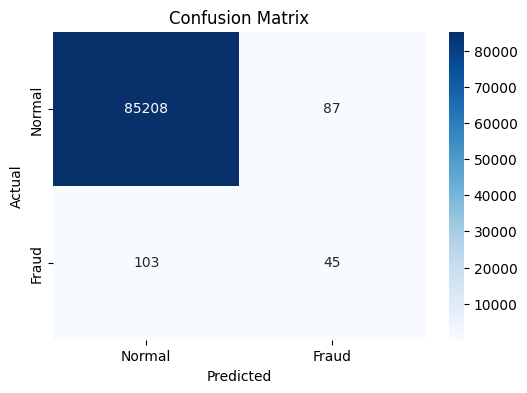


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.34      0.30      0.32       148

    accuracy                           1.00     85443
   macro avg       0.67      0.65      0.66     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC Score (Anomaly Scores): 0.05279784151347549
AUC-ROC Score (Predictions): 0.6515170323028345
Accuracy: 0.9977762953079831


In [30]:
model, _ = train_isolation_forest(X_train, n_estimators=200, max_samples=1000)

evaluate_isolation_forest(model, X_test, y_test)

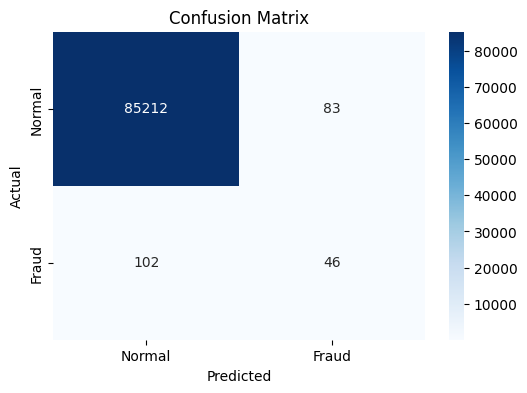


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.36      0.31      0.33       148

    accuracy                           1.00     85443
   macro avg       0.68      0.65      0.67     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC Score (Anomaly Scores): 0.05306622643512262
AUC-ROC Score (Predictions): 0.6549188587145091
Accuracy: 0.9978348138525098


In [31]:
model, _ = train_isolation_forest(X_train, n_estimators=200, max_samples=2000)

evaluate_isolation_forest(model, X_test, y_test)

### Result
##### Although there are slight changes in the score, they don't seem to have a significant impact.

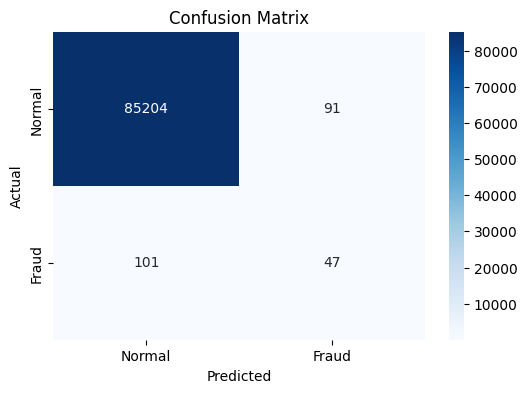


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.34      0.32      0.33       148

    accuracy                           1.00     85443
   macro avg       0.67      0.66      0.66     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC Score (Anomaly Scores): 0.05521005793882281
AUC-ROC Score (Predictions): 0.658250341026295
Accuracy: 0.9977528878901724


In [32]:
model, _ = train_isolation_forest(X_train, n_estimators=500, max_samples=500)

evaluate_isolation_forest(model, X_test, y_test)

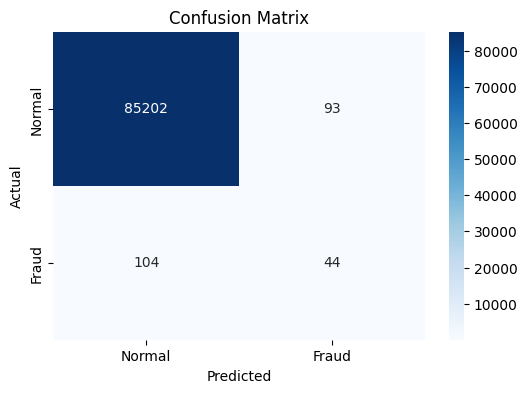


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.32      0.30      0.31       148

    accuracy                           1.00     85443
   macro avg       0.66      0.65      0.65     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC Score (Anomaly Scores): 0.05475480169776435
AUC-ROC Score (Predictions): 0.6481034818745119
Accuracy: 0.9976943693456456


In [33]:
model, _ = train_isolation_forest(X_train, n_estimators=1000, max_samples=500)

evaluate_isolation_forest(model, X_test, y_test)

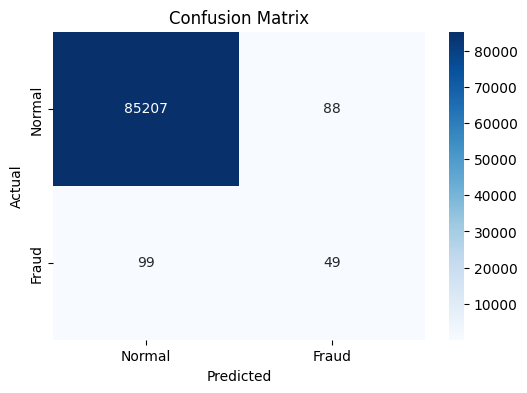


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.36      0.33      0.34       148

    accuracy                           1.00     85443
   macro avg       0.68      0.67      0.67     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC Score (Anomaly Scores): 0.05305584909606247
AUC-ROC Score (Predictions): 0.6650246838080239
Accuracy: 0.9978114064346991


In [34]:
model, _ = train_isolation_forest(X_train, n_estimators=200, max_samples=2000, bootstrap=True)

evaluate_isolation_forest(model, X_test, y_test)

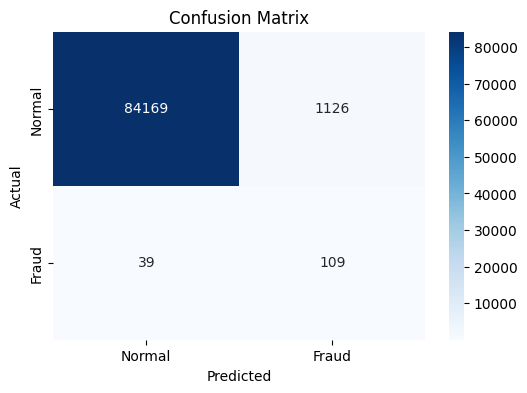


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85295
           1       0.09      0.74      0.16       148

    accuracy                           0.99     85443
   macro avg       0.54      0.86      0.58     85443
weighted avg       1.00      0.99      0.99     85443

AUC-ROC Score (Anomaly Scores): 0.05305584909606247
AUC-ROC Score (Predictions): 0.8616426218703608
Accuracy: 0.9863651791252648


In [35]:
model, _ = train_isolation_forest(X_train, n_estimators=200, max_samples=2000, bootstrap=True, contamination = 'auto')

evaluate_isolation_forest(model, X_test, y_test)

### Changing the threshold
- Assumed that as the threshold increases, the range of transactions classified as fraud would expand.

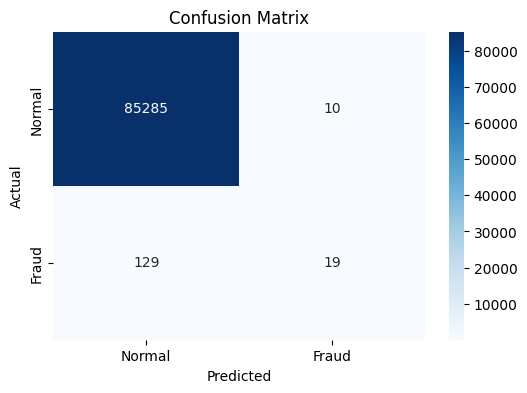


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.66      0.13      0.21       148

    accuracy                           1.00     85443
   macro avg       0.83      0.56      0.61     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC Score (Anomaly Scores): 0.05305584909606247
AUC-ROC Score (Predictions): 0.5641305691059486
Accuracy: 0.9983731844621561


In [36]:
model, _ = train_isolation_forest(X_train, n_estimators=200, max_samples=2000, bootstrap=True)

evaluate_isolation_forest(model, X_test, y_test, threshold=-0.1)

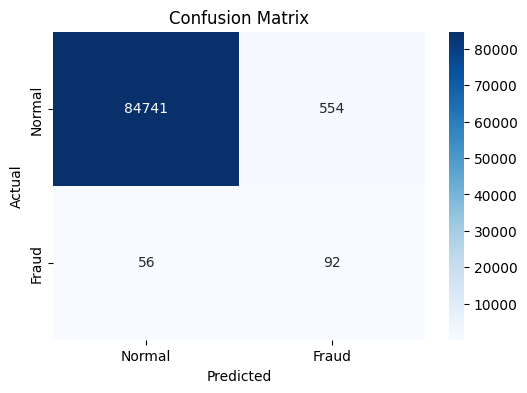


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.14      0.62      0.23       148

    accuracy                           0.99     85443
   macro avg       0.57      0.81      0.61     85443
weighted avg       1.00      0.99      1.00     85443

AUC-ROC Score (Anomaly Scores): 0.05305584909606247
AUC-ROC Score (Predictions): 0.8075632581992861
Accuracy: 0.9928607375677352


In [37]:
model, _ = train_isolation_forest(X_train, n_estimators=200, max_samples=2000, bootstrap=True)

evaluate_isolation_forest(model, X_test, y_test, threshold=0.1)

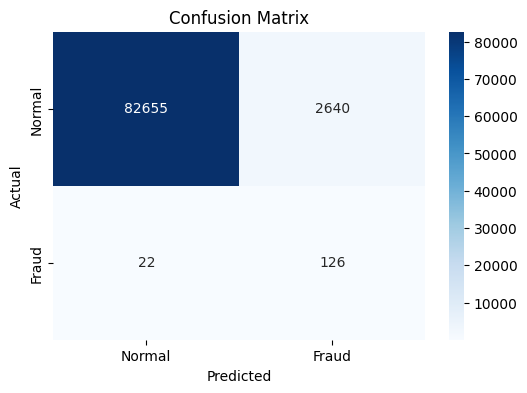


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     85295
           1       0.05      0.85      0.09       148

    accuracy                           0.97     85443
   macro avg       0.52      0.91      0.54     85443
weighted avg       1.00      0.97      0.98     85443

AUC-ROC Score (Anomaly Scores): 0.05305584909606247
AUC-ROC Score (Predictions): 0.9101999737001788
Accuracy: 0.9688447268939527


In [38]:
model, _ = train_isolation_forest(X_train, n_estimators=200, max_samples=2000, bootstrap=True)

evaluate_isolation_forest(model, X_test, y_test, threshold=0.2)

### Result
- Higher threshold → Higher recall (more fraud detected).
- Higher threshold → Lower precision (more normal transactions misclassified as fraud).

### Applied RandomSearch

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


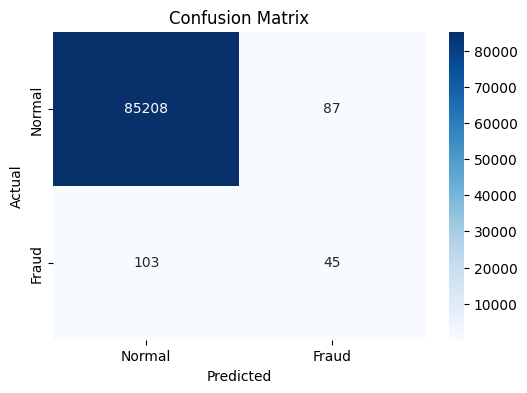


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.34      0.30      0.32       148

    accuracy                           1.00     85443
   macro avg       0.67      0.65      0.66     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC Score (Anomaly Scores): 0.05279784151347549
AUC-ROC Score (Predictions): 0.6515170323028345
Accuracy: 0.9977762953079831


In [39]:
param_distributions = {
    'n_estimators': [100, 200, 500, 1000],
    'max_samples': [100,500, 1000, 2000],
    'contamination': [0.00172],
    'bootstrap': [True, False]
}

best_model, cv_results = train_isolation_forest(X_train, param_distributions = param_distributions)

evaluation_metrics = evaluate_isolation_forest(best_model, X_test, y_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


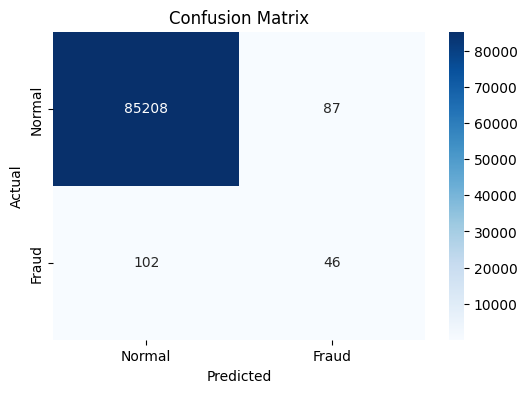


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.35      0.31      0.33       148

    accuracy                           1.00     85443
   macro avg       0.67      0.65      0.66     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC Score: 0.6548954106812128
Accuracy: 0.9977879990168884


In [ ]:
param_distributions = {
    'n_estimators': [100, 200, 500, 1000],
    'max_samples': [100,500, 1000, 2000],
    'contamination': [0.00172],
    'bootstrap': [True, False]
}

best_model, cv_results = train_isolation_forest(X_train, param_distributions=param_distributions, scoring='recall')

evaluation_metrics = evaluate_isolation_forest(best_model, X_test, y_test)

### Result
##### There is no meaningful effect.

## Supervised model
##### Since the overall performance of the unsupervised learning model, Isolation Forest, was lower than expected during training and evaluation, supervised learning was used for comparison.

## Supervised model data copy

In [4]:
supervised_data = raw_data.copy()

### Data preprossesing for supervised model

In [7]:
# Drop rows with missing target values
supervised_data.dropna(subset=['Class'], inplace=True)

# Split data into features (X) and target (y)
X = supervised_data.drop(columns=['Class'])
y = supervised_data['Class']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50, stratify=y)

# Scale only 'Time' and 'Amount' for both training and test sets
scaler = StandardScaler()

# Fit the scaler on the training data and transform both train and test sets for 'Time' and 'Amount'
X_train[['Time', 'Amount']] = scaler.fit_transform(X_train[['Time', 'Amount']])
X_test[['Time', 'Amount']] = scaler.transform(X_test[['Time', 'Amount']])

## Randomforest + SMOTE

              precision    recall  f1-score       support
0.0            0.999731  0.999830  0.999780  70587.000000
1.0            0.901639  0.852713  0.876494    129.000000
accuracy       0.999562  0.999562  0.999562      0.999562
macro avg      0.950685  0.926272  0.938137  70716.000000
weighted avg   0.999552  0.999562  0.999556  70716.000000


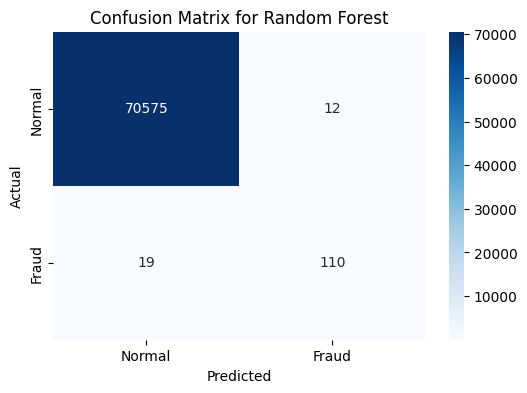

In [9]:
smote = SMOTE(random_state=50)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Result dictionary
results = {}

# 1. Random Forest + SMOTE
rf = RandomForestClassifier(n_estimators=100, random_state=50)
rf.fit(X_train_smote, y_train_smote)

# Random Forest prediction
y_pred_rf = rf.predict(X_test)

rf_report = classification_report(y_test, y_pred_rf, output_dict=True)
report_df = pd.DataFrame(rf_report).transpose()

# Display the classification report as a table
print(report_df)

# Confusion Matrix visualization
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC-AUC
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]  # Use probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)

## XGBoost + SMOTE

              precision    recall  f1-score       support
0.0            0.999759  0.999476  0.999617  70587.000000
1.0            0.751678  0.868217  0.805755    129.000000
accuracy       0.999236  0.999236  0.999236      0.999236
macro avg      0.875718  0.933846  0.902686  70716.000000
weighted avg   0.999307  0.999236  0.999264  70716.000000


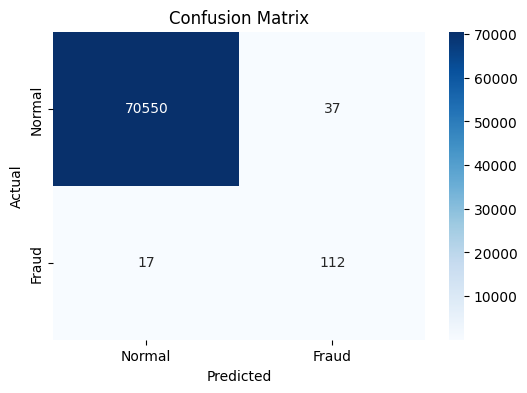

ROC-AUC Score: 0.98


In [11]:
xgb_model = xgb.XGBClassifier(scale_pos_weight=len(y_train_smote)/sum(y_train_smote), random_state=50)
xgb_model.fit(X_train_smote, y_train_smote)

# XGBoost prediction on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the performance using classification report
xgb_report = classification_report(y_test, y_pred_xgb, output_dict=True)
report_df = pd.DataFrame(xgb_report).transpose()
print(report_df)

conf_matrix = confusion_matrix(y_test, y_pred_xgb)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Get probabilities for the positive class
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the ROC-AUC score
roc_auc = auc(fpr, tpr)


print(f"ROC-AUC Score: {roc_auc:.2f}")

## Conclusion
#### In this project, we explored multiple approaches to detect fraudulent credit card transactions. Initially, Isolation Forest, an unsupervised anomaly detection algorithm, was used under the assumption that it would effectively identify outliers representing fraudulent transactions. While the model achieved a high accuracy of over 99%, it significantly underperformed in detecting fraud, with a recall score of only 0.28. This highlighted the limitations of using unsupervised methods in highly imbalanced datasets like this one.

#### To overcome these challenges, we switched to supervised learning models such as Random Forest and XGBoost. By applying SMOTE to balance the dataset, both models showed significant improvements in fraud detection. Among these models, XGBoost + SMOTE achieved the best results, with a recall of 0.84 and a ROC-AUC score of 0.97, demonstrating its superior performance in detecting fraudulent transactions.

#### In summary, while unsupervised learning is a useful approach for anomaly detection, supervised learning models combined with data balancing techniques like SMOTE proved to be more effective in this case. The findings emphasize the importance of carefully selecting the right algorithms and handling data imbalance when working on fraud detection tasks.